In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Add the src folder to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))

import mesh
import geometry
import material
from stress_strain_analysis import stress_strain_analysis

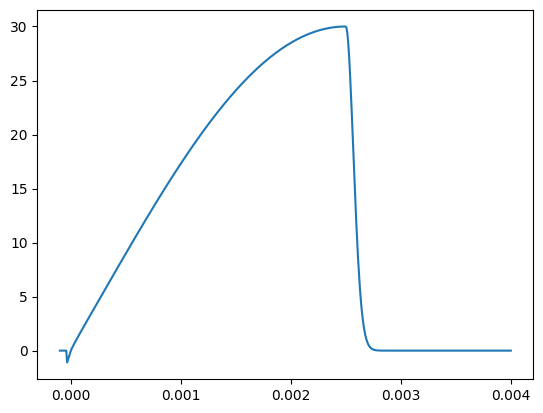

In [2]:
concrete = material.Concrete_C30_37()

strains = np.linspace(-0.0001, 0.004, 500)
stresses = concrete.get_stress_vectorized(strains)

plt.plot(strains, stresses)
plt.show()

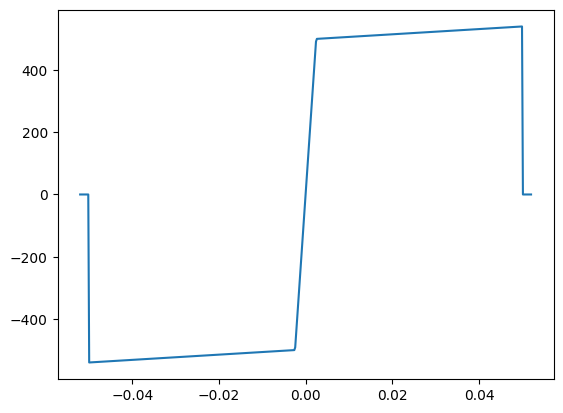

In [3]:
rebar = material.Rebar_B500B()

strains = np.linspace(-0.052, 0.052, 500)
stresses = rebar.get_stress_vectorized(strains)
plt.plot(strains, stresses)
plt.show()

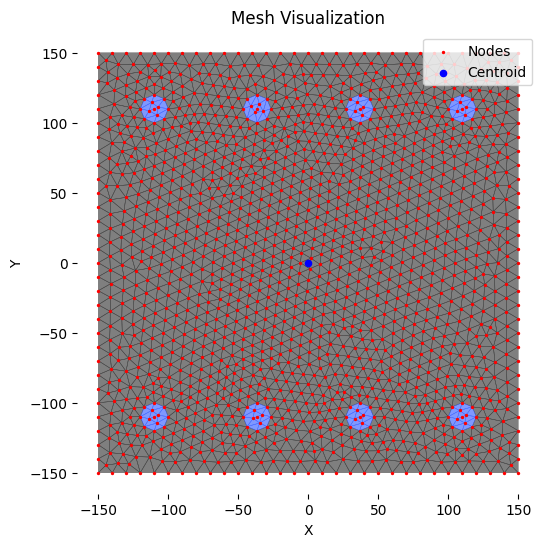

╒════════════════════╤══════════╕
│ Mesh Type          │ triangle │
├────────────────────┼──────────┤
│ Number of elements │ 3116     │
├────────────────────┼──────────┤
│ Number of nodes    │ 1627     │
├────────────────────┼──────────┤
│ Cross Section Area │ 90000.00 │
╘════════════════════╧══════════╛
╒═══════════════════╤══════════════╤══════════════╕
│                   │            X │            Y │
╞═══════════════════╪══════════════╪══════════════╡
│ Centroid          │        -0.00 │         0.00 │
├───────────────────┼──────────────┼──────────────┤
│ Moment of inertia │ 675000000.00 │ 675000000.00 │
╘═══════════════════╧══════════════╧══════════════╛


In [4]:
ReinforcedConcrete = geometry.ReinforcedConcreteColumn(width  = 300, 
                                                       height = 300, 
                                                       concrete_cover = 30,
                                                       rebar_diameter = 20,
                                                       rebar_spacing  = 50)
Mesh = mesh.Mesh(ReinforcedConcrete, "triangle", 10)

Mesh.plot()
Mesh.print()

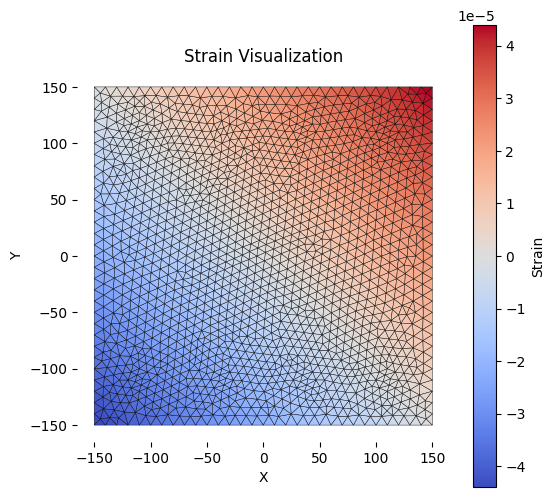

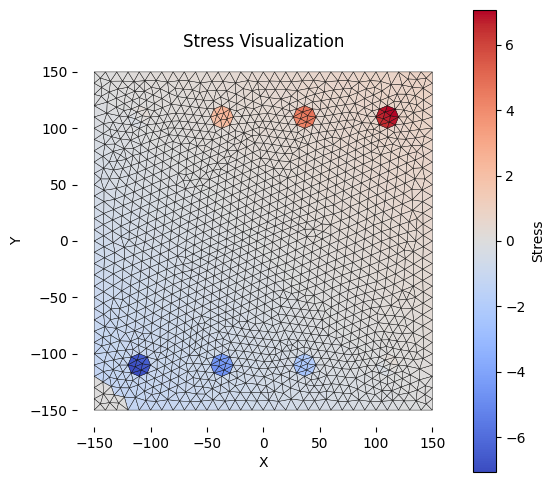

In [5]:
Analysis = stress_strain_analysis(Mesh)

Analysis.set_strain_and_curvature(0.00, 0.00000015, 0.00000015)

Analysis.calculate_strains()
Analysis.plot_strains()

Analysis.calculate_stresses()
Analysis.plot_stresses()

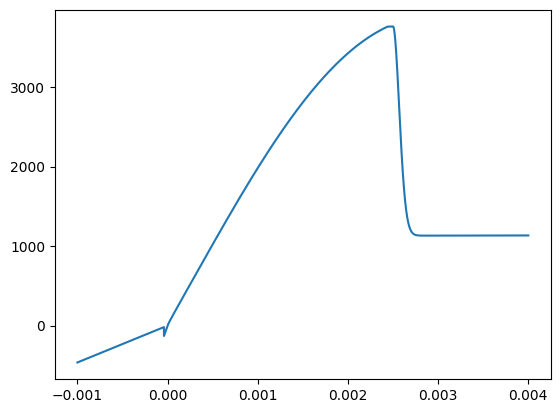

In [6]:
strains = np.linspace(-0.001, 0.004, 10000)

Nx = []

for strain in strains:
    Analysis.set_strain_and_curvature(strain, 0, 0)
    Analysis.calculate_strains()
    Analysis.calculate_stresses()
    Nx.append(Analysis.get_section_forces()[0])

plt.plot(strains, Nx)
plt.show()

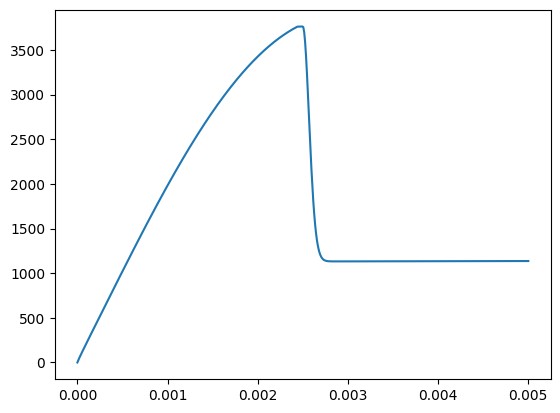

In [7]:
strains = np.linspace(0, 0.005, 500)

Nx = []

for strain in strains:
    Analysis.set_strain_and_curvature(strain, 0, 0)
    Analysis.calculate_strains()
    Analysis.calculate_stresses()
    Nx.append(Analysis.get_section_forces()[0])

plt.plot(strains, Nx)
plt.show()

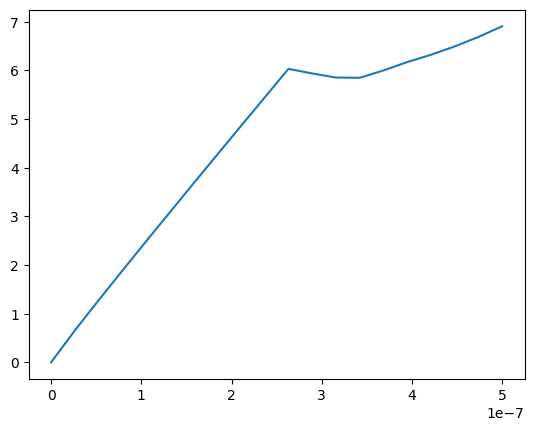

In [8]:
curvs = np.linspace(0, 0.0000005, 20)

My = []

for curv in curvs:
    Analysis.set_strain_and_curvature(0, curv, 0)
    Analysis.calculate_strains()
    Analysis.calculate_stresses()
    My.append(Analysis.get_section_forces()[1])

plt.plot(curvs, My)
plt.show()

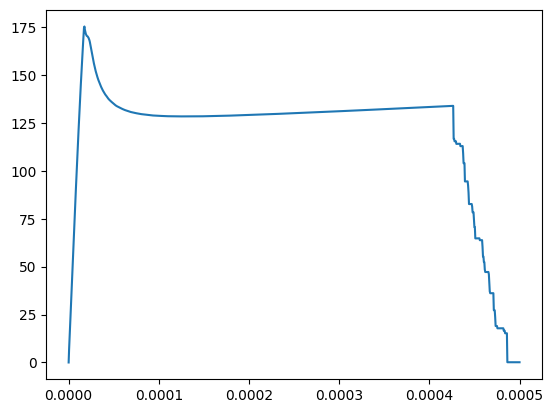

In [9]:
curvs = np.linspace(0, 0.0005, 1000)

My = []

for curv in curvs:
    Analysis.set_strain_and_curvature(0, curv, 0)
    Analysis.calculate_strains()
    Analysis.calculate_stresses()
    My.append(Analysis.get_section_forces()[1])

plt.plot(curvs, My)
plt.show()

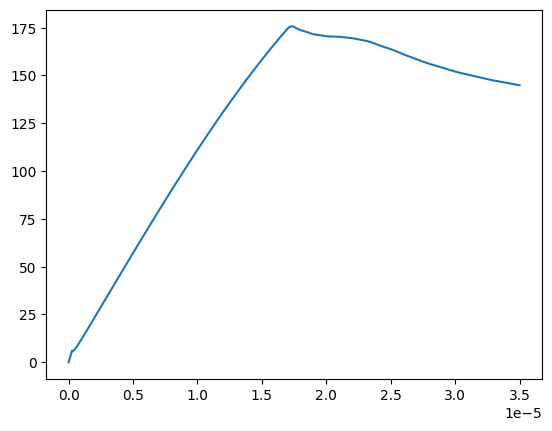

In [10]:
curvs = np.linspace(0, 0.000035, 10000)

My = []

for curv in curvs:
    Analysis.set_strain_and_curvature(0, curv, 0)
    Analysis.calculate_strains()
    Analysis.calculate_stresses()
    My.append(Analysis.get_section_forces()[1])

plt.plot(curvs, My)
plt.show()

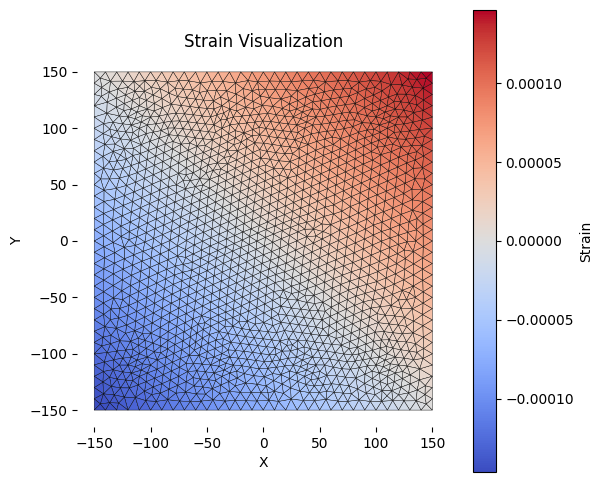

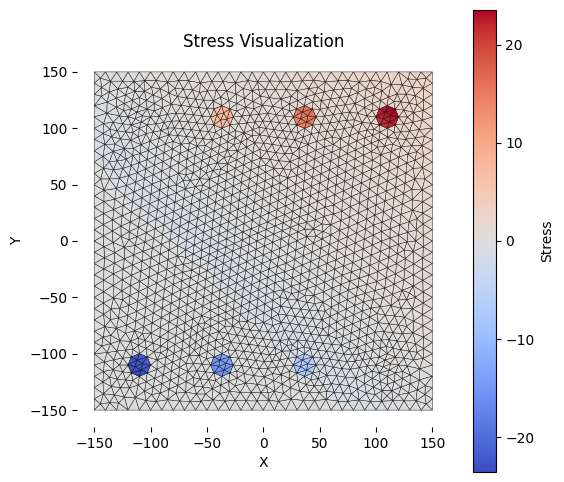

Nx =  31.15586632841779 kN
My =  6.276752022266154 kNm


In [11]:
Analysis.set_strain_and_curvature(0.000, 0.0000005, 0.0000005)
Analysis.calculate_strains()
Analysis.calculate_stresses()
Analysis.plot_strains()
Analysis.plot_stresses()
print("Nx = ", Analysis.get_section_forces()[0], "kN")
print("My = ", Analysis.get_section_forces()[1], "kNm")

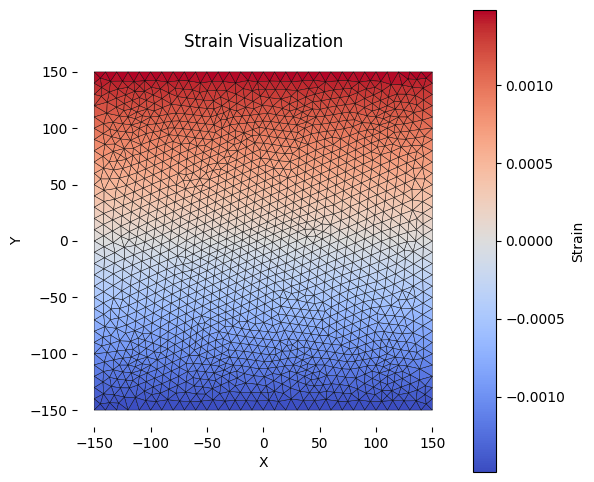

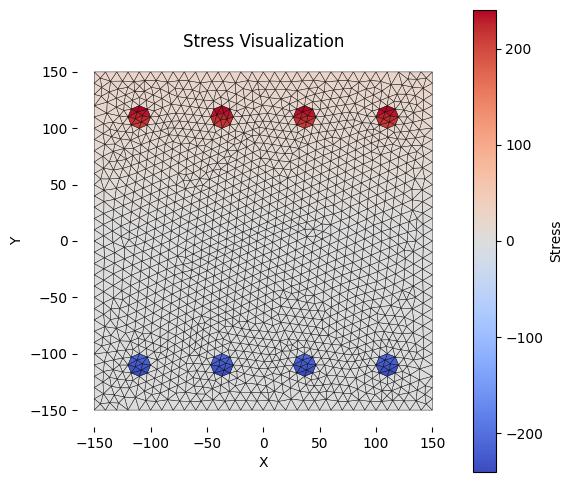

Nx =  558.2920441759501 kN
My =  111.11191220754982 kNm


In [12]:
Analysis.set_strain_and_curvature(0.000, 0.00001, 0.0)
Analysis.calculate_strains()
Analysis.calculate_stresses()
Analysis.plot_strains()
Analysis.plot_stresses()
print("Nx = ", Analysis.get_section_forces()[0], "kN")
print("My = ", Analysis.get_section_forces()[1], "kNm")

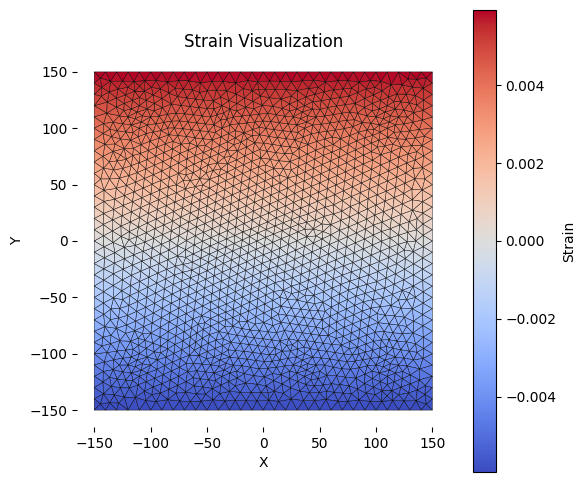

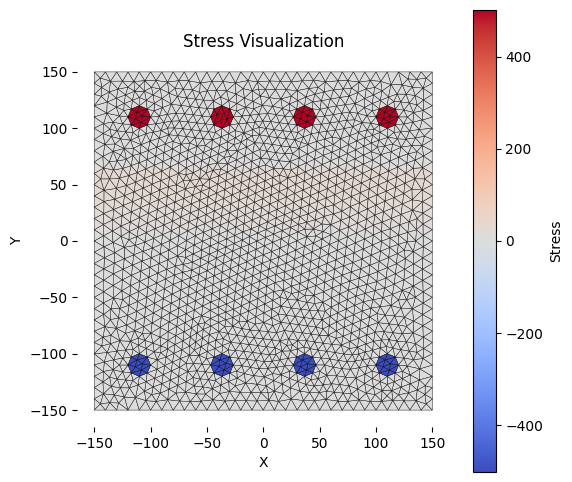

Nx =  373.9941761610704 kN
My =  140.26211659741813 kNm


In [13]:
Analysis.set_strain_and_curvature(0.000, 0.00004, 0.0)
Analysis.calculate_strains()
Analysis.calculate_stresses()
Analysis.plot_strains()
Analysis.plot_stresses()
print("Nx = ", Analysis.get_section_forces()[0], "kN")
print("My = ", Analysis.get_section_forces()[1], "kNm")